In [1]:
import numpy as np
import matplotlib.pyplot as plt
import MDAnalysis as mda
import seaborn as sb
import pandas as pd
from scipy.spatial.distance import cdist
from scipy.spatial import distance_matrix

%matplotlib inline

import nglview as nv

import warnings
warnings.filterwarnings('ignore')

# Process data using MDAnalysis

In [2]:
u_og =  mda.Universe("first.pdb","og.pdb")
ca_og = u_og.select_atoms("name CA")

assert ca_og.universe.trajectory.frame == 0

n_frames = ca_og.universe.trajectory.n_frames
n_atoms = ca_og.n_atoms
frame_start = 0
frame_end = n_frames

ca_og_pos = np.zeros((n_frames, 3*n_atoms))
ca_og_mean_pos = np.zeros((n_atoms, 3))

for i,_ in enumerate(ca_og.universe.trajectory[frame_start:frame_end:1]):
    tmp = ca_og.positions.flatten()
    ca_og_pos[i,:] = tmp
    ca_og_mean_pos += ca_og.positions

ca_og_mean_pos /= (frame_end - frame_start)

In [3]:
u_mod_rt =  mda.Universe("first.pdb","fit_1_rt.pdb")
ca_rt = u_mod_rt.select_atoms("name CA")

assert ca_rt.universe.trajectory.frame == 0

n_frames = ca_rt.universe.trajectory.n_frames
n_atoms = ca_rt.n_atoms
frame_start = 0
frame_end = n_frames

ca_rt_pos = np.zeros((n_frames, 3*n_atoms))
ca_rt_mean_pos = np.zeros((n_atoms, 3))

for i,_ in enumerate(ca_rt.universe.trajectory[frame_start:frame_end:1]):
    tmp = ca_rt.positions.flatten()
    ca_rt_pos[i,:] = tmp
    ca_rt_mean_pos += ca_rt.positions

ca_rt_mean_pos /= (frame_end - frame_start)

In [4]:
u_mod_prog =  mda.Universe("first.pdb","fit_2_p.pdb")
ca_prog = u_mod_prog.select_atoms("name CA")

assert ca_prog.universe.trajectory.frame == 0

n_frames = ca_prog.universe.trajectory.n_frames
n_atoms = ca_prog.n_atoms
frame_start = 0
frame_end = n_frames

ca_prog_pos = np.zeros((n_frames, 3*n_atoms))
ca_prog_mean_pos = np.zeros((n_atoms, 3))

for i,_ in enumerate(ca_prog.universe.trajectory[frame_start:frame_end:1]):
    tmp = ca_prog.positions.flatten()
    ca_prog_pos[i,:] = tmp
    ca_prog_mean_pos += ca_prog.positions

ca_prog_mean_pos /= (frame_end - frame_start)

# 1. Perform PCA on original coordinates

In [5]:
def Cov(X):
    """
    Calculate the covariance matrix.
    Each feature is assumed to be in a column of X.
    So we subtract the mean of each column from each observation (each row value).
    X.mean(axis=0) estimates mean of each column of X.
    Then, the formula is
    Cov = A.T @ A / (N-1)
    N-1 is called Bessel's correction.
    Verify the result with numpy's covariance matrix.
    """
    
    X_scaled = X - X.mean(axis=0) 
    cov = X_scaled.transpose() @ X_scaled / (X_scaled.shape[0] - 1)

    np_cov = np.cov(X, rowvar = False)
    assert abs(cov - np_cov).all() < 1e-8
    assert np.shape(cov) == np.shape(np_cov)

    return cov


In [6]:
def my_pca(X, num_components = 2):
    """
    Do PCA.
    X: Numpy Array
    num_components: Number of components to project to. Default is set to 2.
    """

    X_scaled = X - X.mean(axis = 0)
    
    cov_matrix = Cov(X)
    eigvals , eigvecs = np.linalg.eig(cov_matrix)

    # Sort the eigenvalues
    sorted_index = np.argsort(eigvals)[::-1]
    sorted_eigvals = eigvals[sorted_index]

    # Sort the eigenvectors
    sorted_eigvecs = eigvecs[:,sorted_index]
    eigvec_reduced_dim = sorted_eigvecs[:,0:num_components]

    # Project data on the reduced dimensional eigenvector space
    X_projected = np.dot(eigvec_reduced_dim.transpose(), X_scaled.transpose()).transpose()
    #X_projected = np.dot(X_scaled, eigvec_reduced_dim)
    #X_projected_full = X_scaled @ sorted_eigvecs

    # Make a plot for eigenvalues
    plt.plot(sorted_eigvals, 'b.')
    plt.title("Sorted Eigenvalues")
    plt.xlabel(r"$\lambda$ number")
    plt.ylabel(r"$\lambda$")
    
    print(sorted_eigvals)

    return sorted_eigvals, X_projected, sorted_eigvecs

[6.60517125e+01 5.97120137e+01 5.16884810e+01 2.14160824e+01
 1.99372522e+01 1.85638928e+01 9.37619263e+00 8.64234164e+00
 7.23295481e+00 4.24701932e+00 3.47993151e+00 3.31526754e+00
 2.70329360e+00 2.26603828e+00 1.64118588e+00 5.71213921e-01
 4.47229603e-01 3.67846134e-01 3.32313656e-01 2.69652045e-01
 2.48662094e-01 2.31175149e-01 1.92222649e-01 1.67959875e-01
 8.33448485e-02 7.64858849e-02 7.17164400e-02 6.18503363e-02
 6.06623168e-02 5.05087784e-02]


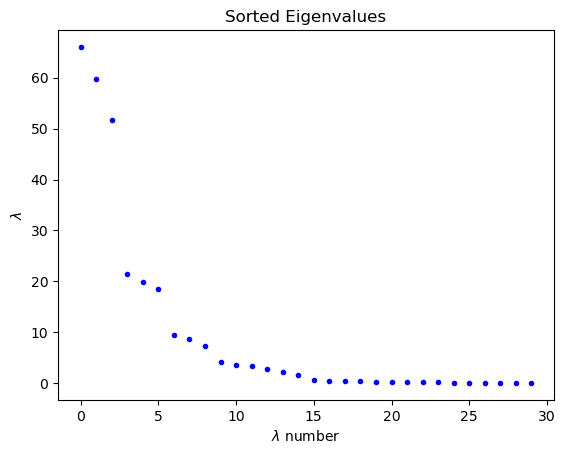

In [7]:
ca_og_eigvals, ca_og_projected, ca_og_eigvecs = my_pca(ca_og_pos,2)

In [8]:
def scree_plot(eigvals, sklearn_PCA):

    PC_values_sklearn = np.arange(sklearn_PCA.n_components_) + 1
    
    variance_contributions = eigvals/np.sum(eigvals)

    PC_values = np.arange(variance_contributions.shape[0]) + 1
    plt.title('Scree Plot')
    plt.plot(PC_values_sklearn, sklearn_PCA.explained_variance_ratio_, 'bo-', label='sklearn PCA')
    plt.plot(PC_values, variance_contributions, 'r.', label='My PCA')
    plt.xlabel('Principal Component')
    plt.ylabel('Proportion of Variance Explained')
    plt.legend()
    plt.show()

    plt.title('Visualize variance change as we add diff PCs')
    plt.ylabel('Explained Variance')
    plt.xlabel('Number of components')
    plt.plot(np.cumsum(sklearn_PCA.explained_variance_ratio_), 'bo-', label='sklearn PCA')
    plt.plot(np.cumsum(variance_contributions), 'r.', label='My PCA')
    plt.legend()
    plt.show()
    
    var_pc_1_2 = variance_contributions[0] + variance_contributions[1]
    print(f"Proportion of variance explained by first 2 PCs = {var_pc_1_2}")

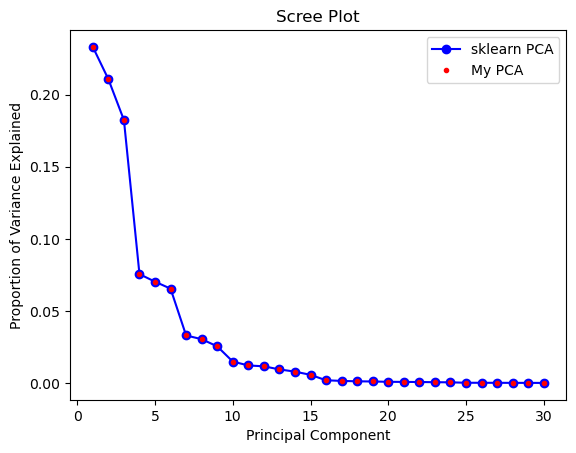

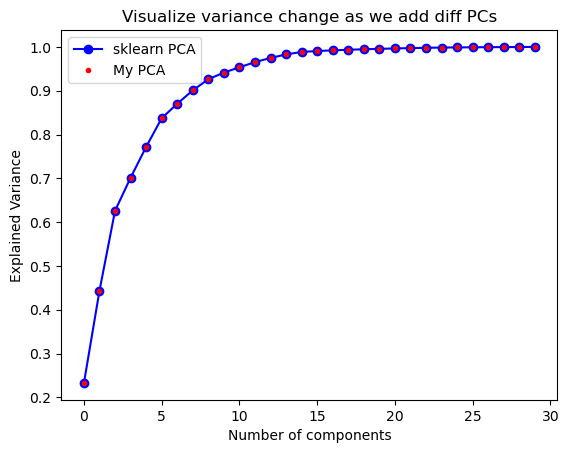

Proportion of variance explained by first 2 PCs = 0.4436008509069932


In [9]:
from sklearn.decomposition import PCA

sklearn_PCA = PCA()
sklearn_PCA.fit(ca_og_pos)
ca_og_pca = sklearn_PCA.transform(ca_og_pos)

scree_plot(ca_og_eigvals, sklearn_PCA)

# 2. Perform PCA on modified coordinates

### There are 2 different versions of alignment I did. Both were done using Gromacs.

#### a) "-fit rot+trans" corresponds to "ca_rt" labelled variables
#### b) "-fit progressive" corresponds to "ca_prog" labelled variables

[7.89146726 4.44004027 2.41637584 1.68044761 1.4758776  1.04203688
 0.95269802 0.79624361 0.59416587 0.47729224 0.38808579 0.385304
 0.26668595 0.23095332 0.19391518 0.16258998 0.16076106 0.13414487
 0.1106222  0.09073382 0.08145589 0.06691158 0.05097544 0.04639758
 0.04096395 0.03138796 0.02329492 0.01709912 0.01339281 0.00949502]


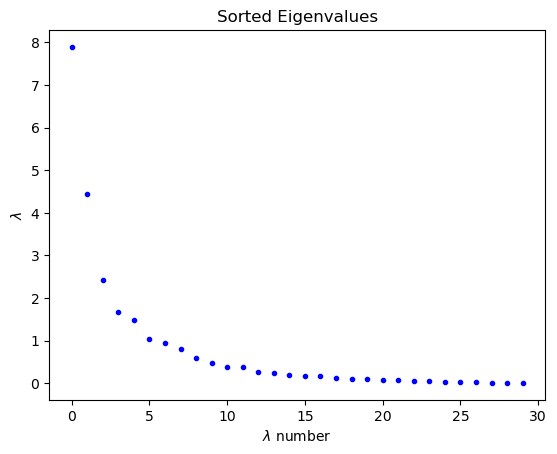

In [10]:
ca_rt_eigvals, ca_rt_projected, ca_rt_eigvecs = my_pca(ca_rt_pos,2)

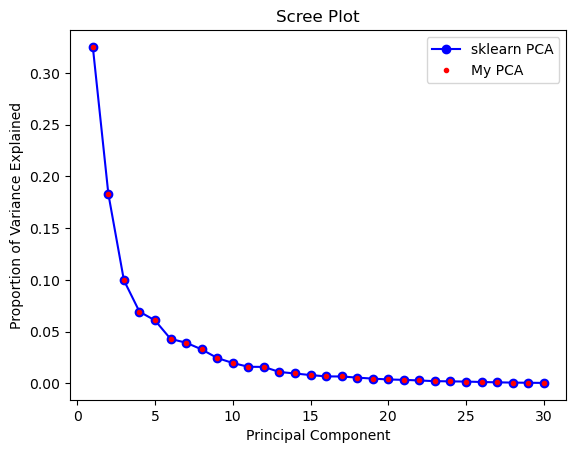

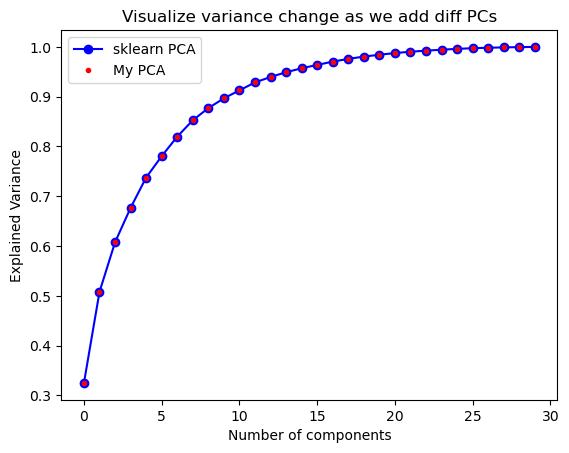

Proportion of variance explained by first 2 PCs = 0.5080587178636033


In [11]:
sklearn_PCA = PCA()
sklearn_PCA.fit(ca_rt_pos)
ca_rt_pca = sklearn_PCA.transform(ca_rt_pos)

scree_plot(ca_rt_eigvals, sklearn_PCA)

#### Plotting the configurations in the space of the first 2 PCs

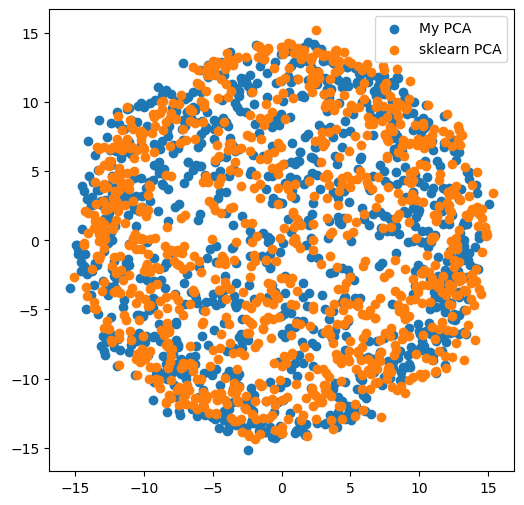

[-5.94198535 -3.92278921 -3.96344504 -4.60338987 -6.54839024 -3.93942148
 -6.93451614 -4.21183977 -2.5749126  -2.56801747]
[5.94198535 3.92278921 3.96344504 4.60338987 6.54839024 3.93942148
 6.93451614 4.21183977 2.5749126  2.56801747]


In [49]:
# plt.figure(figsize=(6,6))
# sb.scatterplot(data = ca_og_projected, s=60 , palette='icefire')
# plt.show()
plt.figure(figsize=(6,6))
plt.scatter(ca_og_projected[:,0],ca_og_projected[:,1],label='My PCA')
plt.scatter(ca_og_pca[:,0],ca_og_pca[:,1],label='sklearn PCA')
plt.legend()
plt.show()

print(ca_og_pca[:10,1])
print(ca_og_projected[:10,1])

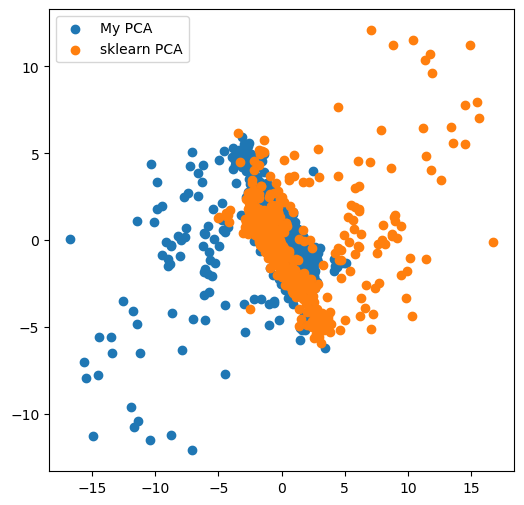

[-0.99559169  0.25154188 -0.31304062 -0.55655973 -0.30955963  0.53404207
  0.40962926 -0.3703348   0.49631925 -0.27519231]
[ 0.99559169 -0.25154188  0.31304062  0.55655973  0.30955963 -0.53404207
 -0.40962926  0.3703348  -0.49631925  0.27519231]


In [48]:
# plt.figure(figsize=(6,6))
# sb.scatterplot(data = ca_rt_projected, s=60 , palette='icefire')
# plt.show()
plt.figure(figsize=(6,6))
plt.scatter(ca_rt_projected[:,0],ca_rt_projected[:,1],label='My PCA')
plt.scatter(ca_rt_pca[:,0],ca_rt_pca[:,1],label='sklearn PCA')
plt.legend()
plt.show()

print(ca_rt_pca[:10,1])
print(ca_rt_projected[:10,1])

In [70]:

from MDAnalysis.analysis import pca as mda_pca
from MDAnalysis.analysis import align as mda_align

test_pc = mda_pca.PCA(u_mod_rt,select="name CA",align=True,mean=None,n_components=None).run()
test_ca = u_mod_rt.select_atoms("name CA")
test_transformed = test_pc.transform(test_ca, n_components=3)

test_df = pd.DataFrame(test_transformed,
                  columns=['PC{}'.format(i+1) for i in range(3)])
test_df['Time (ps)'] = test_df.index * u_mod_rt.trajectory.dt
test_df.head()

#g = sb.PairGrid(test_df, hue='Time (ps)',
                 #palette=sb.color_palette('Oranges_d',
                 #                          n_colors=len(test_df)))
#g.map(plt.scatter, marker='.');


test_pc1 =  test_pc.p_components[:,0]
test_trans1 = test_transformed[:,0]
test_projected = np.outer(test_trans1,test_pc1) + test_pc.mean.flatten()

test_coords = test_projected.reshape(len(test_trans1), -1, 3)

test_proj1 = mda.Merge(test_ca)
test_proj1.load_new(test_coords, order="fac")

# plt.plot(test_pc.cumulated_variance[:10],'b.')
# plt.xlabel('Principal component')
# plt.ylabel('Cumulative variance')
# plt.show()

#view = nv.show_mdanalysis(test_proj1.atoms)
#view

view = nv.MDAnalysisTrajectory(test_proj1.atoms)
view_w = nv.NGLWidget(view)
view_w


NGLWidget(max_frame=999)

        PC1       PC2  Time (ps)
0 -0.272739  0.995592        0.0
1  0.815994 -0.251542        1.0
2  0.379212  0.313041        2.0
3  0.307999  0.556560        3.0
4  1.082974  0.309560        4.0


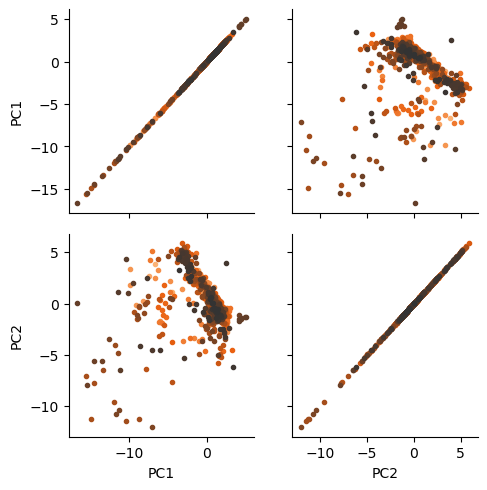

In [15]:
ca_rt_df = pd.DataFrame(ca_rt_projected,
                  columns=['PC{}'.format(i+1) for i in range(2)])
ca_rt_df['Time (ps)'] = ca_rt_df.index * u_mod_rt.trajectory.dt
print(ca_rt_df.head())

ca_rt_sb_plot = sb.PairGrid(ca_rt_df, hue='Time (ps)',
                 palette=sb.color_palette('Oranges_d',
                                           n_colors=len(ca_rt_df)))
ca_rt_sb_plot.map(plt.scatter, marker='.');

In [69]:
rt_proj = np.outer(ca_rt_projected[:,0], ca_rt_eigvecs[:,0]) + ca_rt_mean_pos.flatten()

rt_pc1_coords = rt_proj.reshape(len(ca_rt_projected[:,0]), -1, 3)

rt_proj_pc1 = mda.Merge(ca_rt)
rt_proj_pc1.load_new(rt_pc1_coords, order="fac")

#view_rt = nv.show_mdanalysis(rt_proj_pc1.atoms)
#view_rt
view_rt = nv.MDAnalysisTrajectory(rt_proj_pc1.atoms)
view_rt_w = nv.NGLWidget(view_rt)
view_rt_w

NGLWidget(max_frame=999)

In [67]:
# ncopies=800 
# epsilon=10 
# N=10 
# data=data_saved.copy() 
# pc1=eigvec[:,0] 
# start=np.average(data,axis=0) 
# conf=[] 
# a=np.linspace(-1,1,ncopies) 
# for i in range(ncopies): 
#     conf=np.concatenate([conf,start+a[i]*epsilon*pc1],axis=0) 
# transformation=np.reshape(conf,(ncopies*10,3)) 
# write_PDB(transformation,output='conf_change.pdb') 
# eig_proj =(data-np.average(data,axis=0))@eigvec[:,0] 
# conf=[] 
# for i in range(1000): 
#     conf=np.concatenate([conf,start+eig_proj[i]*pc1]) 
# transformation=np.reshape(conf,(1000*10,3)) 
# write_PDB(transformation,output='conf_change_time.pdb') 



# 3. MDS with dRMSD metric

In [17]:
from scipy.linalg import eig
from scipy.spatial import distance_matrix
from scipy.spatial.distance import pdist

# Testing drmsd

T=500   # Number of time-steps
N=10  # Number of atoms
dim=3 # Number of spatial dimensions of the atoms

np.random.seed(1721313)

## Creating the data

#X = [[np.random.randn(dim) for a in range(N)]for t in range(T)]
X = np.random.randint(1,10,size=(T*N*dim))

X =  np.array(X)
X = X.reshape(T,N,dim)
print(X.shape)

# Creating the distance matrix
d = [cdist(X[t],X[t], metric = 'euclidean')for t in range(T)]
d = np.array(d)
print(d.shape)

drmsd = [np.sqrt(((d[tA][np.triu_indices(N,1)]-d[tB][np.triu_indices(N,1)])**2).sum()/N)for tA in range(T) for tB in range(T)]
drmsd = np.array(drmsd)
drmsd = drmsd.reshape(T,T)
print(drmsd.shape)

d2 = d.reshape(T,-1)
print(d2.shape)

drmsd_2 = distance_matrix(d2,d2)
drmsd_2 = drmsd_2/(np.sqrt(2*N))
print(drmsd_2.shape)

np.max(np.abs(drmsd_2-drmsd))

(500, 10, 3)
(500, 10, 10)
(500, 500)
(500, 100)
(500, 500)


3.552713678800501e-15

In [18]:
X = X.reshape(T,-1)
#print(X.shape)
#print(drmsd)
#print(X)


I = np.identity(T)
Jn = np.ones((T,T))
Jn = Jn/T
C = I - Jn

#print(drmsd.shape)

# Double Centering -> G == B (in wikipedia) -> Gram Matrix
G = -(C @ drmsd @ C)/2
evg,evcg=np.linalg.eig(G)
#print(evg)
#print(G)


assert np.allclose(G, G.T, atol=1.0e-8)
assert np.allclose(np.abs(np.sum(G,axis=0)),0.0, atol=1.0e-08)
assert np.allclose(np.abs(np.sum(G,axis=1)),0.0, atol=1.0e-08)

sigma = 2.0
#print("KERNEL")
drmsd_transformed = np.exp(-drmsd/(2*(sigma**2)))
#print(drmsd_transformed)

kpca = [np.exp((-np.sqrt(((d[tA][np.triu_indices(N,1)]-d[tB][np.triu_indices(N,1)])**2).sum()/N))/(2*(sigma**2)))for tA in range(T) for tB in range(T)]
kpca = np.array(kpca)
kpca = kpca.reshape(T,T)
#print(kpca.shape)
#print(kpca)

assert np.abs(kpca-drmsd_transformed).all() < 1.0e-8

K = np.exp(-drmsd**2/(2*(sigma**2)))

#print("KPCA DIST MAT")
#print(K)
#print(K.shape)

G_K = (K - (Jn @ K) - (K @ Jn) + (Jn @ K @ Jn))

assert np.allclose(G_K, G_K.T, atol=1.0e-8)
assert np.allclose(np.abs(np.sum(G_K,axis=0)),0.0, atol=1.0e-08)
assert np.allclose(np.abs(np.sum(G_K,axis=1)),0.0, atol=1.0e-08)

#print(G_K)
#print(G_K.shape)
evgk,evcgk=np.linalg.eig(G_K)
#print(evgk)


In [19]:
def drmsd(X):
    T = X.shape[0]
    X = X.reshape(T,-1,3)
    
    print(X.shape)

    _,N,_ = X.shape

    d = [cdist(X[t], X[t], metric = 'euclidean')for t in range(T)]
    d = np.array(d)
    print(d.shape)

    #drmsd_mat = [np.sqrt(((d[tA][np.triu_indices(N,1)] - d[tB][np.triu_indices(N,1)])**2).sum()/N)for tA in range(T) for tB in range(T)]
    #drmsd_mat = np.array(drmsd_mat)
    #drmsd_mat = drmsd_mat.reshape(T,T)
    #print(drmsd_mat.shape)

    d = d.reshape(T,-1)
    #print(d.shape)

    drmsd_mat = distance_matrix(d,d)
    drmsd_mat = drmsd_mat/(np.sqrt(2*N)) 
    # sqrt(2) since the i>j criteria is ignored and (1/2) comes inside sqrt
    # Also, sqrt(N) since N comes inside the sqrt
    print(drmsd_mat.shape)

    return drmsd_mat

#drmsd(ca_rt_pos)
    

In [20]:
def my_mds(X, num_components = 2):
    """
    Do MDS. Here the distance metric is the "dRMSD".
    X: Numpy Array
    num_components: Number of components to project to. Default is set to 2.
    """

    T = X.shape[0] # number of data points <-> number of timesteps
    dist_matrix = np.zeros((T,T)) # delta_{i,j} from notes

    dist_matrix = drmsd(X)

    I = np.identity(T)
    Jn = np.ones((T,T))
    Jn = Jn/T
    C = I - Jn

    # Double Centering -> G == B (in wikipedia: MDS algo section) -> Gram Matrix
    # Ref for formula: http://www.cs.umd.edu/~djacobs/CMSC828/MDSexplain.pdf (Pg. 2)
    # https://en.wikipedia.org/wiki/Multidimensional_scaling#Classical_multidimensional_scaling
    G = -(C @ dist_matrix @ C)/2

    # Verify properties of Gram Matrix
    assert np.allclose(G, G.T, atol=1.0e-8)
    assert np.allclose(np.abs(np.sum(G,axis=0)),0.0, atol=1.0e-08)
    assert np.allclose(np.abs(np.sum(G,axis=1)),0.0, atol=1.0e-08)

    eigvals, eigvecs = np.linalg.eig(G)

    # Sort the eigenvalues
    sorted_index = np.argsort(eigvals)[::-1]
    sorted_eigvals = eigvals[sorted_index]
    eigvals_reduced_dim = sorted_eigvals[0:num_components]
    eigval_mat = np.diag(eigvals_reduced_dim)

    # Sort the eigenvectors
    sorted_eigvecs = eigvecs[:,sorted_index]
    eigvec_reduced_dim = sorted_eigvecs[:,0:num_components]

    X_projected = eigvec_reduced_dim @ np.sqrt(eigval_mat)
    print(X_projected.shape)   

    # Make a plot for eigenvalues
    plt.plot(sorted_eigvals, 'b.')
    plt.title("Sorted Eigenvalues")
    plt.xlabel(r"$\lambda$ number")
    plt.ylabel(r"$\lambda$")
    
    #print(sorted_eigvals)

    return sorted_eigvals, X_projected

(1000, 10, 3)
(1000, 10, 10)
(1000, 1000)
(1000, 2)


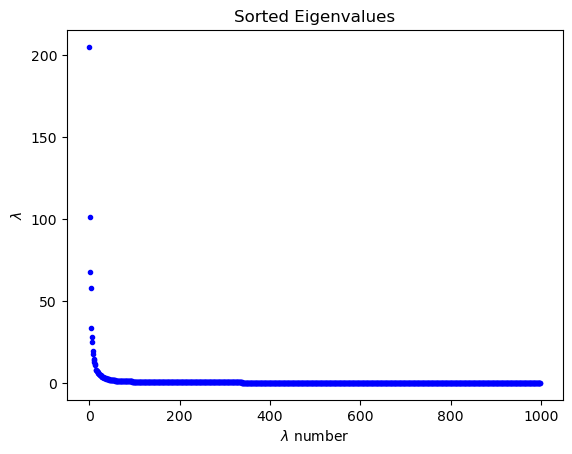

In [21]:
ca_rt_mds_eigvals, ca_rt_mds_projected = my_mds(ca_rt_pos)

In [36]:
def scree_plot_mds(eigvals, label_str='MDS'):
    
    variance_contributions = eigvals/np.sum(eigvals)

    PC_values = np.arange(variance_contributions.shape[0]) + 1
    plt.title('Scree Plot')
    plt.plot(PC_values, variance_contributions, 'r.', label=label_str)
    plt.xlabel('Principal Component')
    plt.ylabel('Proportion of Variance Explained')
    plt.legend()
    plt.show()

    plt.title('Visualize variance change as we add diff PCs')
    plt.ylabel('Explained Variance')
    plt.xlabel('Number of components')
    plt.plot(np.cumsum(variance_contributions), 'b.', label=label_str)
    plt.legend()
    plt.show()

    var_pc_1_2 = variance_contributions[0] + variance_contributions[1]
    print(f"Proportion of variance explained by first 2 PCs = {var_pc_1_2}")

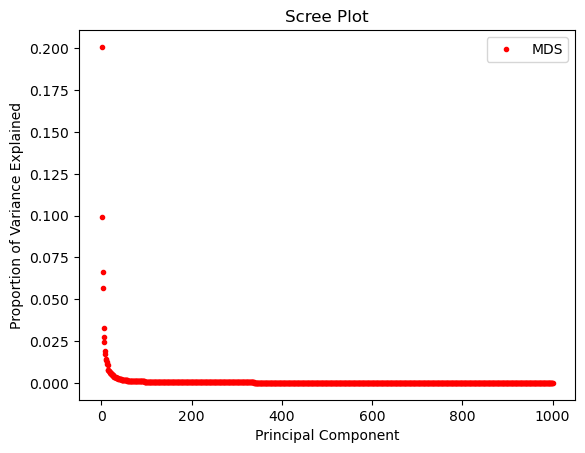

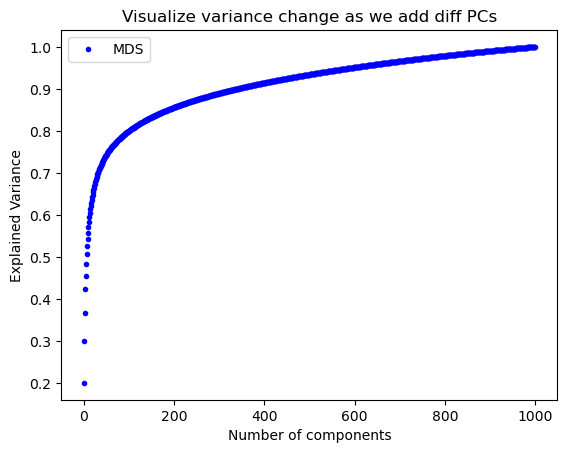

Proportion of variance explained by first 2 PCs = 0.2997775566324393


In [37]:
scree_plot_mds(ca_rt_mds_eigvals,label_str='MDS')

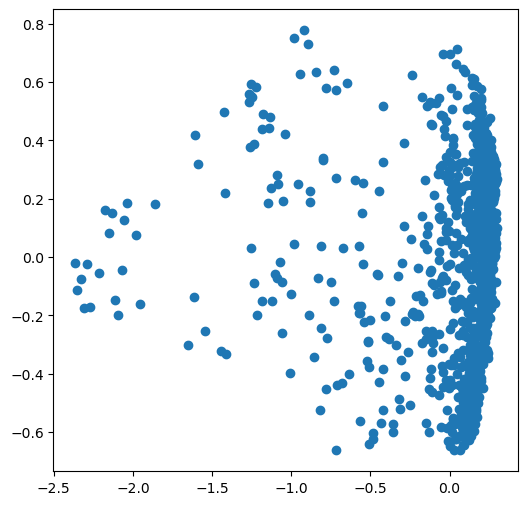

In [24]:
plt.figure(figsize=(6,6))
plt.scatter(ca_rt_mds_projected[:,0],ca_rt_mds_projected[:,1])
plt.show()

#print(ca_rt_mds_projected[:10,1])
#print(ca_rt_mds_projected.shape)

        PC1       PC2  Time (ps)
0  0.008355  0.580545        0.0
1  0.158563  0.508198        1.0
2  0.186553  0.357460        2.0
3  0.166292  0.527544        3.0
4  0.211117 -0.110512        4.0


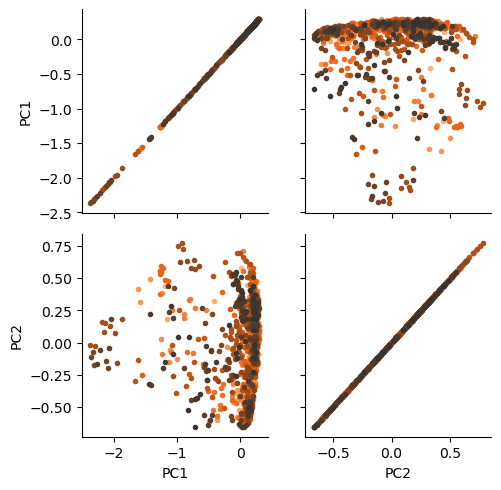

In [25]:
ca_rt_mds_df = pd.DataFrame(ca_rt_mds_projected,
                  columns=['PC{}'.format(i+1) for i in range(2)])
ca_rt_mds_df['Time (ps)'] = ca_rt_mds_df.index * u_mod_rt.trajectory.dt
print(ca_rt_mds_df.head())

ca_rt_mds_sb_plot = sb.PairGrid(ca_rt_mds_df, hue='Time (ps)',
                 palette=sb.color_palette('Oranges_d',
                                           n_colors=len(ca_rt_mds_df)))
ca_rt_mds_sb_plot.map(plt.scatter, marker='.');

# 4. Kernel Transformation of dRMSD

In [26]:
def kernel_drmsd(X):
    T = X.shape[0]
    X = X.reshape(T,-1,3)
    
    print(X.shape)

    _,N,_ = X.shape

    d = [cdist(X[t], X[t], metric = 'euclidean')for t in range(T)]
    d = np.array(d)
    print(d.shape)

    #drmsd_1 = [np.sqrt(((d[tA][np.triu_indices(N,1)] - d[tB][np.triu_indices(N,1)])**2).sum()/N)for tA in range(T) for tB in range(T)]
    #drmsd_1 = np.array(drmsd_1)
    #drmsd_1 = drmsd_1.reshape(T,T)
    #print(drmsd_mat.shape)

    d = d.reshape(T,-1)
    #print(d.shape)

    drmsd_mat = distance_matrix(d,d)
    drmsd_mat = drmsd_mat/(np.sqrt(2*N)) 
    # sqrt(2) since the i>j criteria is ignored and (1/2) comes inside sqrt
    # Also, sqrt(N) since N comes inside the sqrt
    print(drmsd_mat.shape)

    #assert (np.abs(drmsd_mat-drmsd_1)).all() < 1.0e-8

    return drmsd_mat

#drmsd(ca_rt_pos)
    

In [27]:
def my_kpca(X, gamma, c, kernel_type = 'gaussian', degree = 5, num_components = 2):
    """
    Do Kernel PCA. 
    Here the distance metric is the "dRMSD".
    Then we do a kernel transformation of dRMSD.
    The goal is to maximize variance captured by PC1 and PC2.
    X: Numpy Array
    num_components: Number of components to project to. Default is set to 2.
    """

    T = X.shape[0] # number of data points <-> number of timesteps
    dist_matrix = np.zeros((T,T)) # delta_{i,j} from notes

    dist_matrix = kernel_drmsd(X)

    # gamma = n_features is common choice
    if kernel_type == 'gaussian':
        c = 0
        K = 1 - np.exp(-(dist_matrix**2)/(gamma))
    elif kernel_type == 'tanh':
        K = np.tanh(((dist_matrix**2)/gamma)+c)
    elif kernel_type == 'polynomial':
        limit_val = np.power(np.max(np.abs(dist_matrix)),degree)
        #print(limit_val)
        coeffs = np.random.randint(int(limit_val)+1, int(10*limit_val), size=(degree))
        coeffs= 1/coeffs
        #print(coeffs)
        p=np.poly1d(coeffs)
        K = p(((dist_matrix**2)/gamma)+c)

    Jn = np.ones((T,T))
    Jn = Jn/T

    # Double Centering -> G
    # Formula for double centering:
    # https://arxiv.org/pdf/1207.3538.pdf
    # https://sebastianraschka.com/Articles/2014_kernel_pca.html#implementing-the-rbf-kernel-pca-step-by-step
    # Same formula as in mds() function, just expanded explicitly
    # The -1/2 term from class (not in the refs) is kept for consistency
    G = -0.5*(K - (Jn @ K) - (K @ Jn) + (Jn @ K @ Jn))

    # Verify properties of Gram Matrix
    assert np.allclose(G, G.T, atol=1.0e-8)
    assert np.allclose(np.abs(np.sum(G,axis=0)), 0.0, atol=1.0e-08)
    assert np.allclose(np.abs(np.sum(G,axis=1)), 0.0, atol=1.0e-08)

    eigvals, eigvecs = np.linalg.eig(G)

    # Sort the eigenvalues
    sorted_index = np.argsort(eigvals)[::-1]
    sorted_eigvals = eigvals[sorted_index]
    eigvals_reduced_dim = sorted_eigvals[0:num_components]
    eigval_mat = np.diag(eigvals_reduced_dim)

    # Sort the eigenvectors
    sorted_eigvecs = eigvecs[:,sorted_index]
    eigvec_reduced_dim = sorted_eigvecs[:,0:num_components]

    X_projected = eigvec_reduced_dim @ np.sqrt(eigval_mat)
    print(X_projected.shape)   

    #print(np.max(dist_matrix))

    # Make a plot for eigenvalues
    plt.plot(sorted_eigvals, 'b.')
    plt.title("Sorted Eigenvalues")
    plt.xlabel(r"$\lambda$ number")
    plt.ylabel(r"$\lambda$")
    
    #print(sorted_eigvals)

    return sorted_eigvals, X_projected

(1000, 10, 3)
(1000, 10, 10)
(1000, 1000)
(1000, 2)


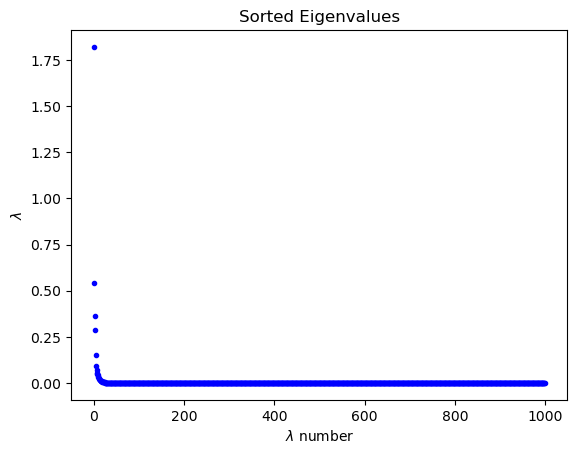

In [38]:
ca_rt_kpca_eigvals, ca_rt_kpca_projected = my_kpca(ca_rt_pos, gamma=1000, c=0, kernel_type='gaussian')

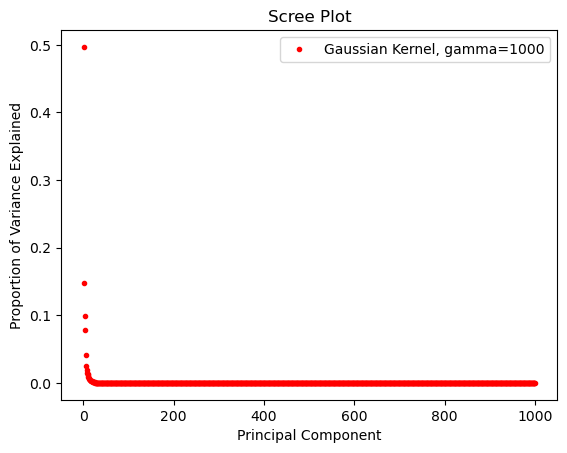

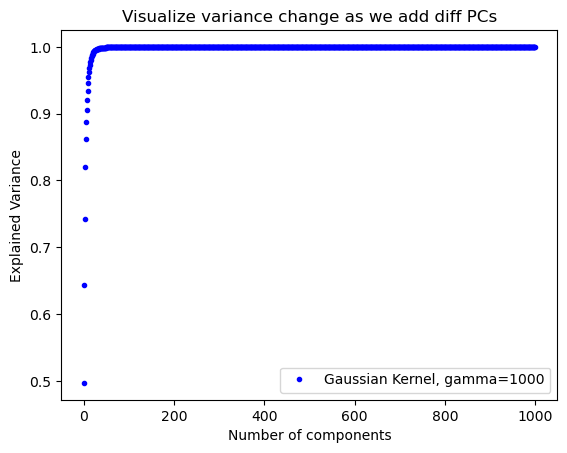

Proportion of variance explained by first 2 PCs = 0.6442049106564298


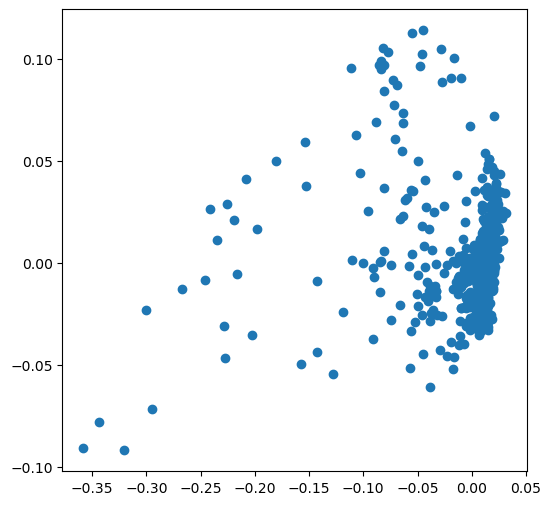

In [39]:
scree_plot_mds(ca_rt_kpca_eigvals,label_str='Gaussian Kernel, gamma=1000')
plt.figure(figsize=(6,6))
plt.scatter(ca_rt_kpca_projected[:,0],ca_rt_kpca_projected[:,1])
plt.show()

(1000, 10, 3)
(1000, 10, 10)
(1000, 1000)
(1000, 2)


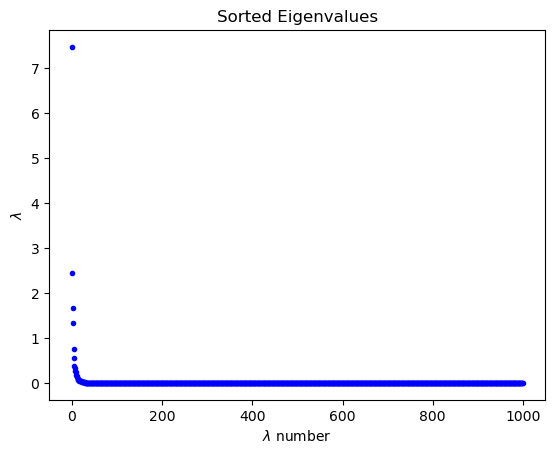

In [40]:
ca_rt_kpca_eigvals, ca_rt_kpca_projected = my_kpca(ca_rt_pos, gamma=200, c=0, kernel_type='gaussian')

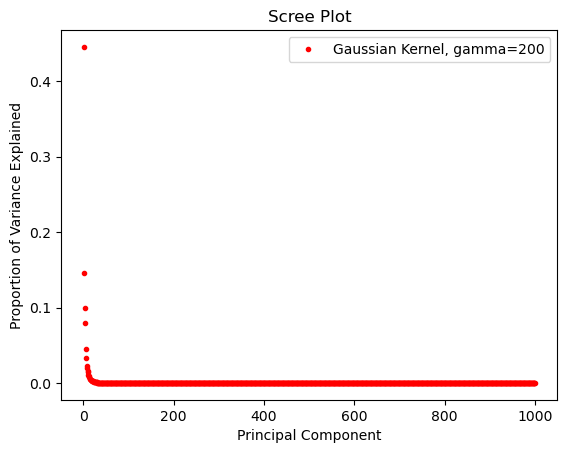

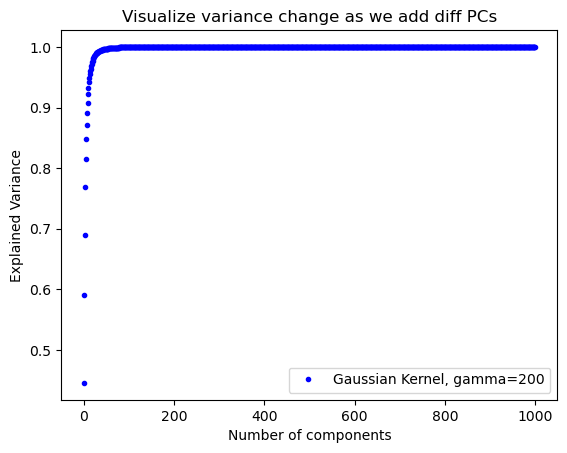

Proportion of variance explained by first 2 PCs = 0.5907861642293004


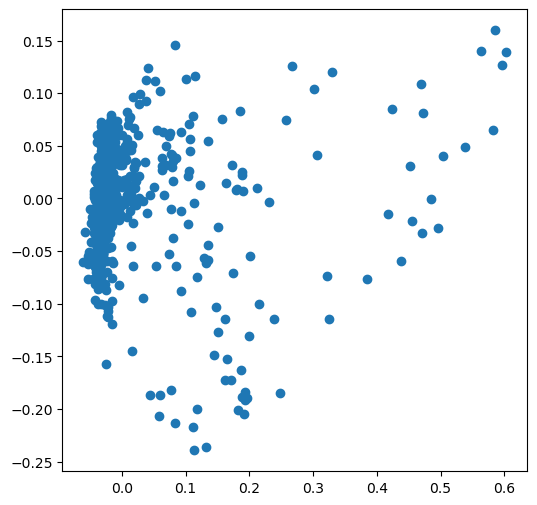

In [41]:
scree_plot_mds(ca_rt_kpca_eigvals,label_str='Gaussian Kernel, gamma=200')
plt.figure(figsize=(6,6))
plt.scatter(ca_rt_kpca_projected[:,0],ca_rt_kpca_projected[:,1])
plt.show()

(1000, 10, 3)
(1000, 10, 10)
(1000, 1000)
(1000, 2)


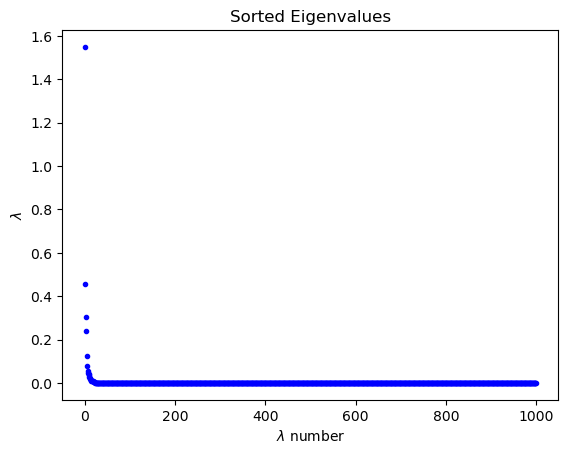

In [43]:
ca_rt_kpca_eigvals, ca_rt_kpca_projected = my_kpca(ca_rt_pos, gamma=1100, c=0.3, kernel_type='tanh')

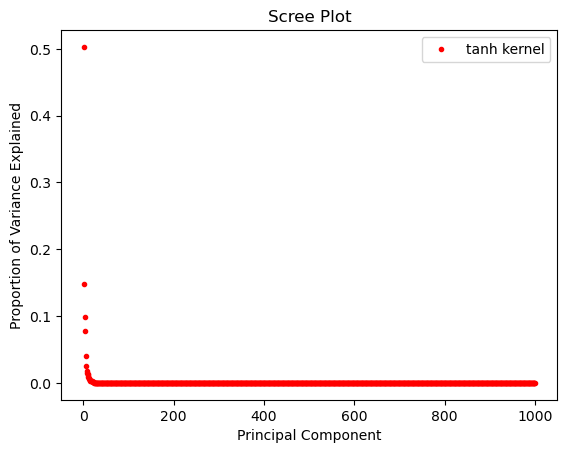

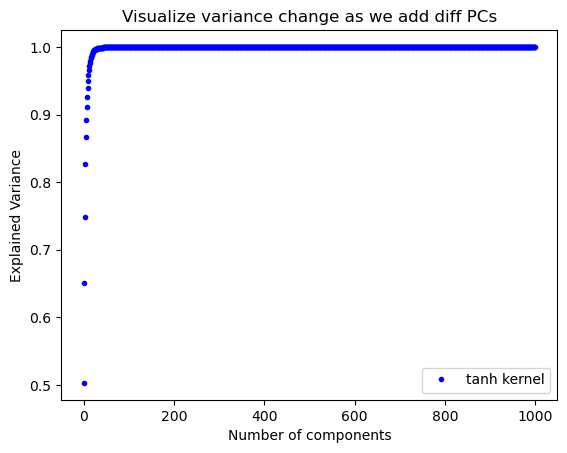

Proportion of variance explained by first 2 PCs = 0.6504391684234437


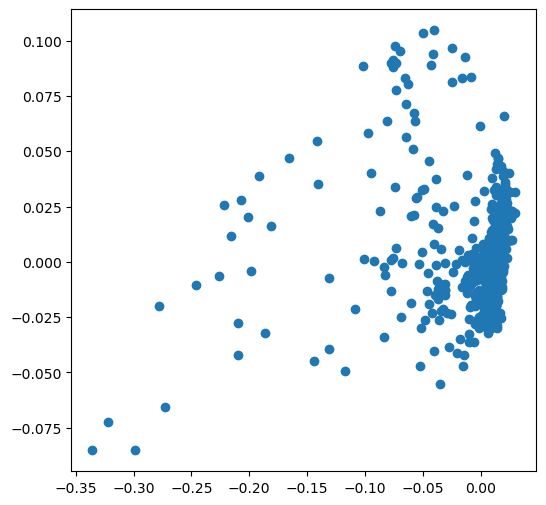

In [44]:
scree_plot_mds(ca_rt_kpca_eigvals, label_str='tanh kernel')
plt.figure(figsize=(6,6))
plt.scatter(ca_rt_kpca_projected[:,0],ca_rt_kpca_projected[:,1])
plt.show()

(1000, 10, 3)
(1000, 10, 10)
(1000, 1000)
(1000, 2)


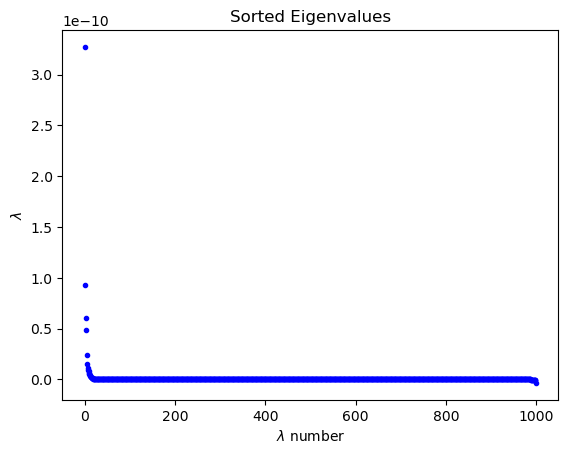

In [45]:
ca_rt_kpca_eigvals, ca_rt_kpca_projected = my_kpca(ca_rt_pos, gamma=2200, c=0.3, kernel_type='polynomial', degree=8)

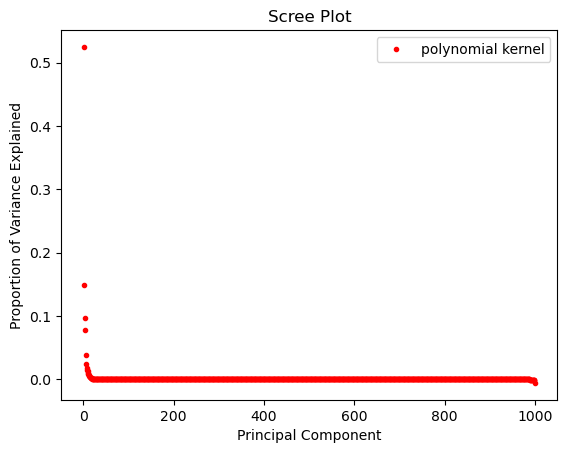

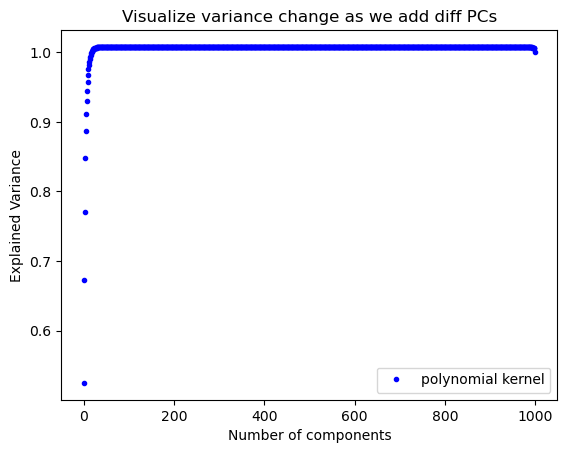

Proportion of variance explained by first 2 PCs = 0.6730508282701582


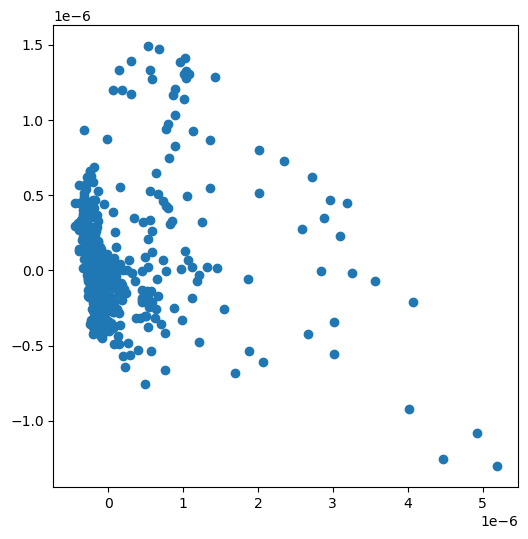

In [46]:
scree_plot_mds(ca_rt_kpca_eigvals, label_str='polynomial kernel')
plt.figure(figsize=(6,6))
plt.scatter(ca_rt_kpca_projected[:,0],ca_rt_kpca_projected[:,1])
plt.show()